In [65]:
import pandas as pd
import numpy as np
import psycopg2 as pg
import psycopg2.extras
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1️⃣ Build a Clean Feature Set per Item

At the item_id level, you should compute:
avg_monthly_sales 
cv_sales
freq_ratio
unit_cost (optional if you have)
lead_time (optional)
avg_line_cost

In [66]:
df = pd.read_csv('../data/antal_consegne23_24.xlsx - Dettaglio ordini e consegne.csv')
df = df[['so_date', 'item_id', 'so_quantity', 'actual_lt']]
df = df.rename(columns={'so_quantity':'quantity', 'actual_lt':'lt'})
df = df.drop(df[df.so_date == ' '].index) # include only sold lines
df = df.drop(df[(df.so_date < '2023-01-01') & (df.so_date > '2025-03-01')].index) # limit to 2023 till 2025-02 incl.

df.so_date = pd.to_datetime(df.so_date)
df['month'] = df.so_date.dt.to_period('M')

df['lt'] = df['lt'].astype(str).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29910 entries, 0 to 32533
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   so_date   29910 non-null  datetime64[ns]
 1   item_id   29910 non-null  object        
 2   quantity  29910 non-null  int64         
 3   lt        29910 non-null  int64         
 4   month     29910 non-null  period[M]     
dtypes: datetime64[ns](1), int64(2), object(1), period[M](1)
memory usage: 1.4+ MB


In [67]:
# cost
cost = pd.read_csv('../data/antal_article_value.csv', decimal='.', thousands=',')
cost = cost[['category', 'item_id', 'unit_value']]
cost = cost.rename(columns={'unit_value':'unit_cost'})
cost['unit_cost'] = cost['unit_cost'].astype(str).astype(float)
cost = cost.drop_duplicates('item_id', keep='first') # keep only recent values
cost.head()
cost.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1977 entries, 0 to 3994
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   category   1977 non-null   object 
 1   item_id    1977 non-null   object 
 2   unit_cost  1976 non-null   float64
dtypes: float64(1), object(2)
memory usage: 61.8+ KB


In [68]:
mdf = df.merge(cost.drop_duplicates('item_id', keep='first'), how='left')
mdf = mdf[mdf.unit_cost > 0] # keep only items that have a price
#mdf = mdf[mdf.unit_cost <= 200] # keep only items that have a low price
mdf['line_cost'] = mdf.quantity * mdf.unit_cost
mdf.info()
mdf

<class 'pandas.core.frame.DataFrame'>
Index: 26743 entries, 0 to 29909
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   so_date    26743 non-null  datetime64[ns]
 1   item_id    26743 non-null  object        
 2   quantity   26743 non-null  int64         
 3   lt         26743 non-null  int64         
 4   month      26743 non-null  period[M]     
 5   category   26743 non-null  object        
 6   unit_cost  26743 non-null  float64       
 7   line_cost  26743 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2), period[M](1)
memory usage: 1.8+ MB


,so_date,item_id,quantity,lt,month,category,unit_cost,line_cost
0,2024-04-24,00517,2,35,2024-04,Rinvii (95),24.68,49.36
1,2024-04-24,00818Z,3,35,2024-04,Rinvii (95),98.25,294.75
2,2024-04-24,04919F,2,35,2024-04,Pulegge (90),24.49,48.98
3,2024-04-24,10021A,2,35,2024-04,Pulegge (90),45.87,91.74
4,2024-04-24,501.110,8,35,2024-04,Stopper (120),48.53,388.24
...,...,...,...,...,...,...,...,...
29905,2023-06-05,HS22.40S,5,12,2023-06,Full Batten (50),21.28,106.40
29906,2023-08-29,R07.05,10,4,2023-08,Soft Link (110),5.49,54.90
29907,2023-08-29,R10.07,10,4,2023-08,Soft Link (110),6.53,65.30
29908,2023-08-29,R14.10,10,4,2023-08,Soft Link (110),7.66,76.60


In [69]:
# dropping null cost items makes sense - they are all uncategoried, too (probably mostly Y- articles)
# the result is dropping 995 unique articles or about 3600 lines
no_costs = mdf[mdf.unit_cost.isna()]
no_costs = no_costs[['item_id', 'category']].drop_duplicates().fillna('unknown')
agg = no_costs.groupby('category').category.size()
agg

Series([], Name: category, dtype: int64)

In [70]:
# create a full article-date set
items = mdf.item_id.unique()
mdf['month'] = mdf.so_date.dt.to_period('M')
months = pd.period_range(mdf.month.min(), mdf.month.max(), freq='M')
full_index = pd.MultiIndex.from_product([items, months], names=['item_id', 'month'])

#group by month
monthly_sales = (mdf.groupby(['item_id', 'month'])
                 .agg(
                    quantity=("quantity", "sum"),
                    avg_lt=('lt', 'mean'),
                    avg_unit_cost=('unit_cost', 'mean')
                    )
                 .reset_index())

sales = (monthly_sales.set_index(['item_id', 'month'])
         .reindex(full_index)
         .reset_index())

sales['quantity'] = sales['quantity'].fillna(0) # avg_lt, avg_unit_cost, avg_line_cost stay NaN
sales['avg_line_cost'] = sales.avg_unit_cost * sales.quantity # recompute the average line cost


sales = pd.merge(sales, cost[['item_id', 'category']].drop_duplicates(keep='first'), how='left')

print(len(sales))
print(sales.info())
sales.head()

50571
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50571 entries, 0 to 50570
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype    
---  ------         --------------  -----    
 0   item_id        50571 non-null  object   
 1   month          50571 non-null  period[M]
 2   quantity       50571 non-null  float64  
 3   avg_lt         12677 non-null  float64  
 4   avg_unit_cost  12677 non-null  float64  
 5   avg_line_cost  12677 non-null  float64  
 6   category       50571 non-null  object   
dtypes: float64(4), object(2), period[M](1)
memory usage: 2.7+ MB
None


,item_id,month,quantity,avg_lt,avg_unit_cost,avg_line_cost,category
0,00517,2023-01,0.0,NaN,NaN,NaN,Rinvii (95)
1,00517,2023-02,2.0,26.0,24.68,49.36,Rinvii (95)
2,00517,2023-03,0.0,NaN,NaN,NaN,Rinvii (95)
3,00517,2023-04,0.0,NaN,NaN,NaN,Rinvii (95)
4,00517,2023-05,4.0,16.0,24.68,98.72,Rinvii (95)


In [71]:
stats = (sales.groupby(['category', 'item_id'])
         .agg(avg_monthly_sales=("quantity", "mean"), 
                    std=("quantity", "std"),
                    avg_unit_cost=('avg_unit_cost', 'mean'),
                    avg_lead_time=('avg_lt', 'mean')
                    )
         .reset_index())
stats['avg_total_value'] = stats.avg_monthly_sales * stats.avg_unit_cost
stats['cv_sales'] = stats['std'] / stats['avg_monthly_sales'].replace(0, np.nan)


n_months = sales.month.nunique()
freq_ratio = (
    sales.groupby('item_id')['quantity']
    .apply(lambda x: (x>0).sum())
    /n_months
)
freq_ratio = freq_ratio.to_frame().reset_index()
freq_ratio = freq_ratio.rename(columns={'quantity':'freq_ratio'})
stats = pd.merge(stats, freq_ratio, how='left', on='item_id')

stats = stats.drop(columns=['std'])
stats.head()

,category,item_id,avg_monthly_sales,avg_unit_cost,avg_lead_time,avg_total_value,cv_sales,freq_ratio
0,Accessori (10),005LS,0.185185,2.12,0.000000,0.392593,5.196152,0.037037
1,Accessori (10),005SS,0.296296,2.20,2.000000,0.651852,5.196152,0.037037
2,Accessori (10),006HR,1.444444,9.50,23.000000,13.722222,2.200468,0.222222
3,Accessori (10),006SS,0.592593,2.12,16.833333,1.256296,3.042517,0.111111
4,Accessori (10),008HR,2.555556,14.55,20.981481,37.183333,1.790991,0.333333


# 3️⃣ Exploratory Data Analysis (EDA)
	•	Histograms of sales_value, avg_monthly_sales, unit_cost
	•	Scatterplots: avg_monthly_sales vs. cv_sales, unit_cost vs. frequency
	•	Identify:
	•	Outliers (huge volume or price)
	•	“Dead” items (rare/no sales)
	•	“Noisy” items (unstable sales)



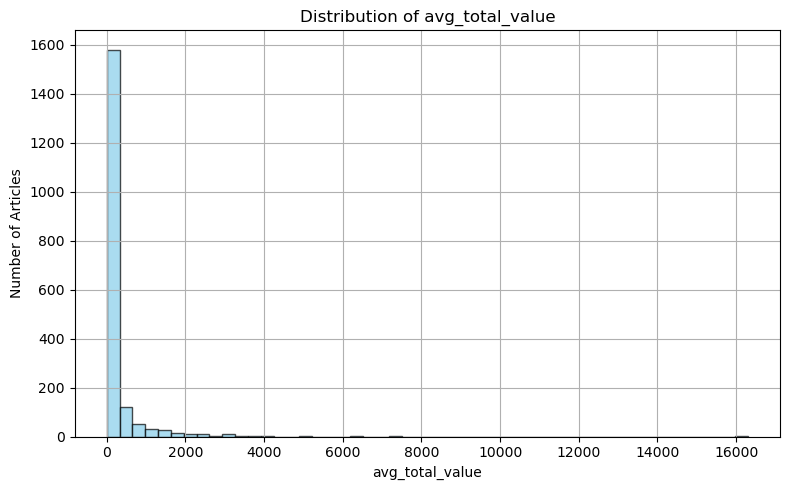

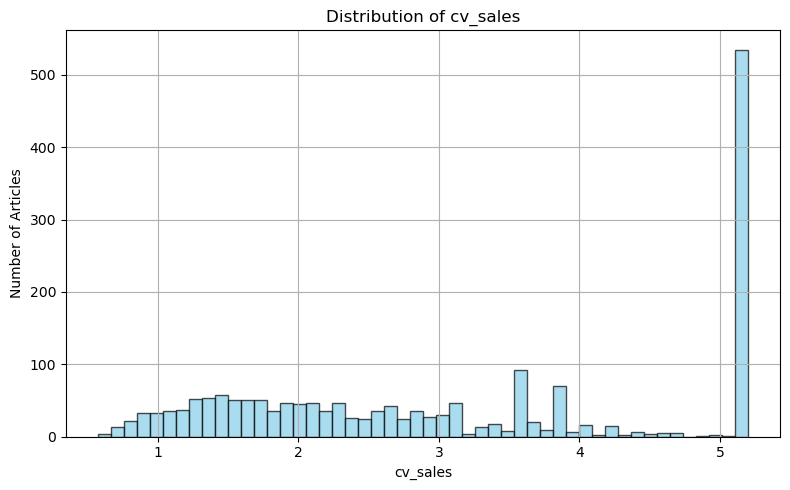

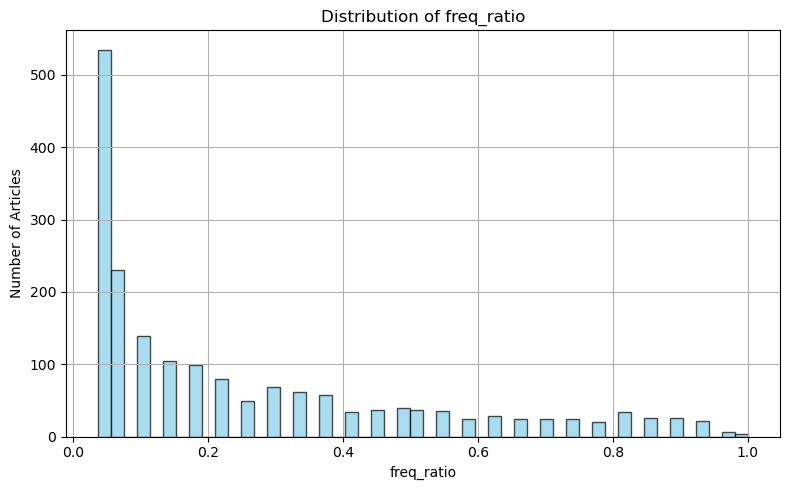

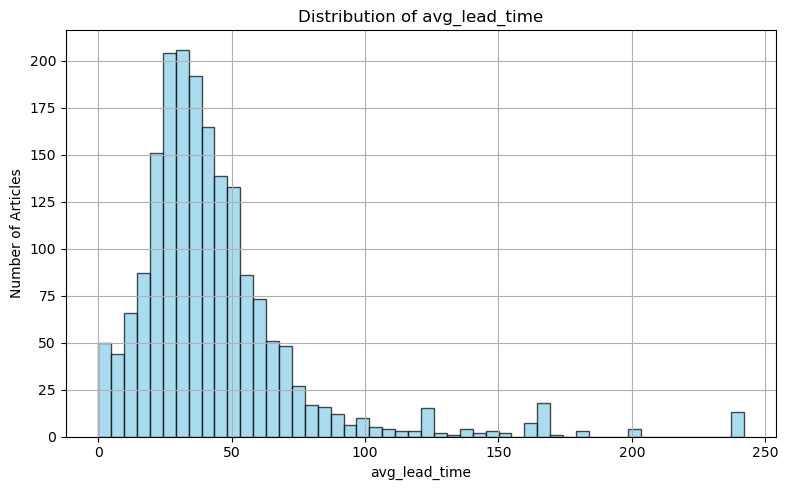

In [72]:
features_to_plot = ['avg_total_value', 'cv_sales', 'freq_ratio', 'avg_lead_time']

for feature in features_to_plot:
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(stats[feature].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Number of Articles')
    ax.grid(True)
    max_t = max(stats[feature])
    #ax.xaxis.set_ticks(np.arange(0,max_t+1, round((max_t+1)/12,-1))) #plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.tight_layout()
    plt.show()

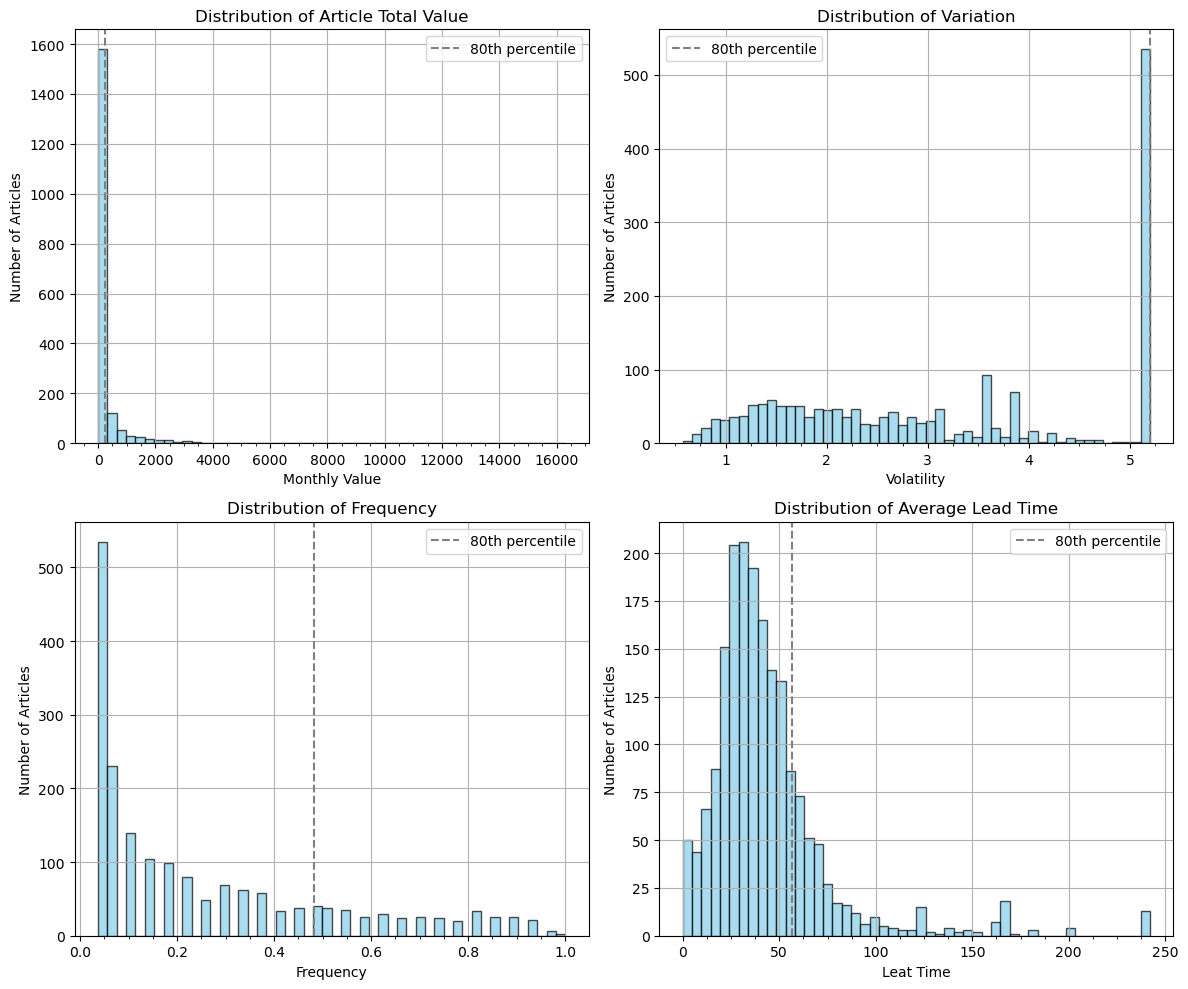

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Create figure and axes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Unpack axes for easy handling
(ax1, ax2), (ax3, ax4) = axes

# First plot: avg_total_value
ax1.hist(stats['avg_total_value'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title('Distribution of Article Total Value')
ax1.set_xlabel('Monthly Value')
ax1.set_ylabel('Number of Articles')
ax1.grid(True)
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))  # 2 minor ticks between majors
q80 = stats['avg_total_value'].quantile(0.8)
ax1.axvline(q80, color='grey', linestyle='--', label='80th percentile')
ax1.legend()


# Second plot: cv_sales
ax2.hist(stats['cv_sales'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax2.set_title('Distribution of Variation')
ax2.set_xlabel('Volatility')
ax2.set_ylabel('Number of Articles')
ax2.grid(True)
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))
q80 = stats['cv_sales'].quantile(0.8)
ax2.axvline(q80, color='grey', linestyle='--', label='80th percentile')
ax2.legend()

# Third plot: freq_ratio
ax3.hist(stats['freq_ratio'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax3.set_title('Distribution of Frequency')
ax3.set_xlabel('Frequency')
ax3.set_ylabel('Number of Articles')
ax3.grid(True)
ax3.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))
q80 = stats['freq_ratio'].quantile(0.8)
ax3.axvline(q80, color='grey', linestyle='--', label='80th percentile')
ax3.legend()

# Fourth plot: avg_lead_time
ax4.hist(stats['avg_lead_time'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax4.set_title('Distribution of Average Lead Time')
ax4.set_xlabel('Leat Time')
ax4.set_ylabel('Number of Articles')
ax4.grid(True)
ax4.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))
q80 = stats['avg_lead_time'].quantile(0.8)
ax4.axvline(q80, color='grey', linestyle='--', label='80th percentile')
ax4.legend()

# Adjust layout
plt.tight_layout()
plt.show()

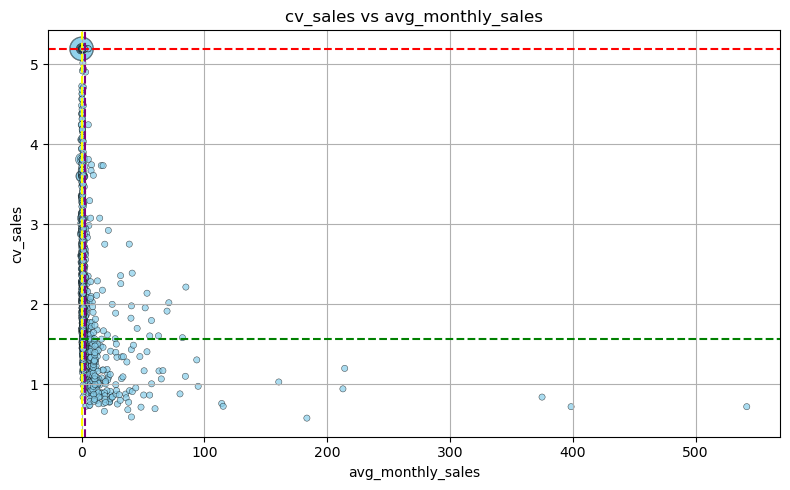

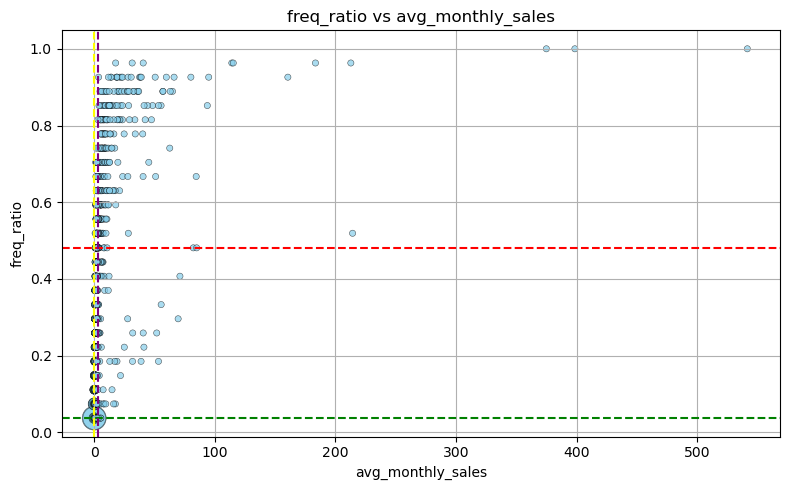

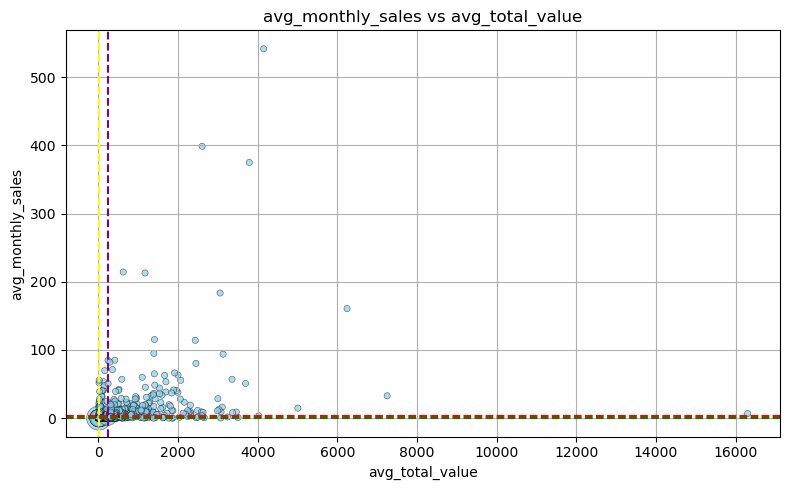

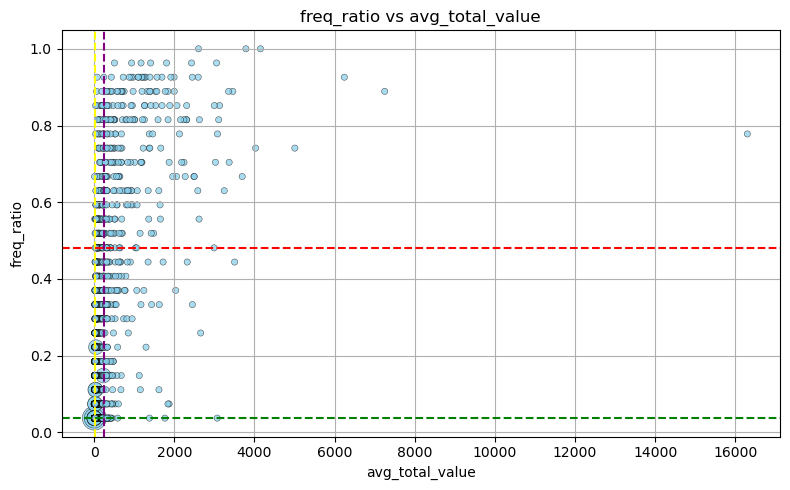

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

pairs = [
    ('avg_monthly_sales', 'cv_sales'),
    ('avg_monthly_sales', 'freq_ratio'),
    ('avg_total_value', 'avg_monthly_sales'),
    ('avg_total_value', 'freq_ratio')
]

for x, y in pairs:
    # Group by (x, y) and count duplicates
    coords = stats[[x, y]].round(3)   # Optional: round to avoid floating point noise
    counts = coords.value_counts().reset_index(name='count')

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.scatterplot(
        data=counts, 
        x=x, 
        y=y, 
        size='count',           # 👈 Size proportional to number of points
        sizes=(20, 300),         # Min/max dot size
        legend=False,            # Hide size legend if too messy
        ax=ax,
        alpha=0.7,
        color='skyblue',
        edgecolor='black'
    )

    ax.set_title(f'{y} vs {x}')
    ax.grid(True)

    # Threshold lines
    threshold_1 = stats[x].quantile(0.2)
    threshold_2 = stats[y].quantile(0.2)
    threshold_3 = stats[y].quantile(0.8)
    threshold_4 = stats[x].quantile(0.8)

    plt.axvline(threshold_1, color='yellow', linestyle='--')
    plt.axhline(threshold_2, color='green', linestyle='--')
    plt.axhline(threshold_3, color='red', linestyle='--')
    plt.axvline(threshold_4, color='purple', linestyle='--')

    plt.tight_layout()
    plt.show()

In [75]:
# Example: Top 1% of items by average monthly sales
outliers_sales = stats[stats['avg_monthly_sales'] > stats['avg_monthly_sales'].quantile(0.99)]

# Items with huge unit cost
outliers_cost = stats[stats['avg_unit_cost'] > stats['avg_unit_cost'].quantile(0.98)]

# Items with extremely high CV (unstable)
outliers_cv = stats[stats['cv_sales'] > 2.5]  # or another threshold

# items that have low frequency
dead_items = stats[stats['freq_ratio'] < 0.1]  # sold in <10% of months

# items with poor stability and low frequency
noisy_items = stats[(stats['cv_sales'] > 2) & (stats['freq_ratio'] < 0.4)]

outliers_summary = []

for idx, row in outliers_sales.iterrows():
    outliers_summary.append({'outlier_type': 'high_sales', 'item_id': row['item_id']})

for idx, row in outliers_cost.iterrows():
    outliers_summary.append({'outlier_type': 'high_cost', 'item_id': row['item_id']})

for idx, row in outliers_cv.iterrows():
    outliers_summary.append({'outlier_type': 'unstable_sales', 'item_id': row['item_id']})

for idx, row in dead_items.iterrows():
    outliers_summary.append({'outlier_type': 'dead_items', 'item_id': row['item_id']})

for idx, row in noisy_items.iterrows():
    outliers_summary.append({'outlier_type': 'noisy_items', 'item_id': row['item_id']})

outliers_summary = pd.DataFrame(outliers_summary)


noutliers = len(outliers_summary['item_id'].unique())
nids = len(stats['item_id'].unique())
print(f'There are {noutliers} outliers and {nids - noutliers} remaining values')
goutliers = outliers_summary.groupby('outlier_type').size()
display(goutliers)

outlier_check = pd.merge(stats, outliers_summary.drop_duplicates('item_id', keep='first'), how='left').fillna('ok')
outlier_check.to_csv('../data/outlier_check.csv')

There are 1292 outliers and 581 remaining values


outlier_type
dead_items         766
high_cost           38
high_sales          19
noisy_items       1268
unstable_sales    1078
dtype: int64

In [76]:
raw_features = ['avg_monthly_sales', 'avg_unit_cost', 'avg_lead_time', 'avg_total_value', 'cv_sales', 'freq_ratio']
scaled_features = ['sales_is','unit_cost_s','lt_is','cv_s','freq_ratio_is']

In [77]:
outlier_check.groupby('outlier_type')[raw_features].mean().round(3)

,avg_monthly_sales,avg_unit_cost,avg_lead_time,avg_total_value,cv_sales,freq_ratio
outlier_type,,,,,,
high_cost,0.149,6439.099,98.712,768.744,4.583,0.072
high_sales,163.596,14.156,25.830,1957.059,1.145,0.797
noisy_items,1.952,140.999,41.601,104.389,2.224,0.235
ok,7.574,150.316,36.915,553.549,1.440,0.558
unstable_sales,0.494,279.884,46.746,48.700,4.249,0.079


# 2️⃣ Scaling and Inverting Where Necessary

Prepare two views of your features:
	•	Raw features (for interpretation, visuals)
	•	Scaled/Inverted features (for clustering and PCA)

➡️ Make sure higher = “better” before clustering (e.g., high frequency good, low CV good).



In [78]:
stats2 = outlier_check[outlier_check.outlier_type == 'ok']
stats2 = stats2[raw_features + ['category', 'item_id']]

stats2

,avg_monthly_sales,avg_unit_cost,avg_lead_time,avg_total_value,cv_sales,freq_ratio,category,item_id
4,2.555556,14.55,20.981481,37.183333,1.790991,0.333333,Accessori (10),008HR
16,9.000000,24.94,31.621667,224.460000,1.171034,0.740741,Accessori (10),7206
17,10.888889,31.60,37.585281,344.088889,1.062884,0.814815,Accessori (10),7208
19,13.296296,35.18,43.685507,467.763704,1.164350,0.851852,Accessori (10),7210
20,55.481481,37.23,39.961886,2065.575556,0.865202,0.851852,Accessori (10),7212
...,...,...,...,...,...,...,...,...
1827,0.925926,1753.30,56.777778,1623.425926,1.744689,0.333333,Winch XT (200),XT52EH24AL
1838,1.407407,1167.70,42.104167,1643.429630,0.990419,0.592593,Winch XT (200),XT62AL
1841,1.703704,1905.15,54.558824,3245.811111,1.077568,0.629630,Winch XT (200),XT62EH24AL
1849,0.555556,1533.30,71.071429,851.833333,1.822931,0.259259,Winch XT (200),XT66AL


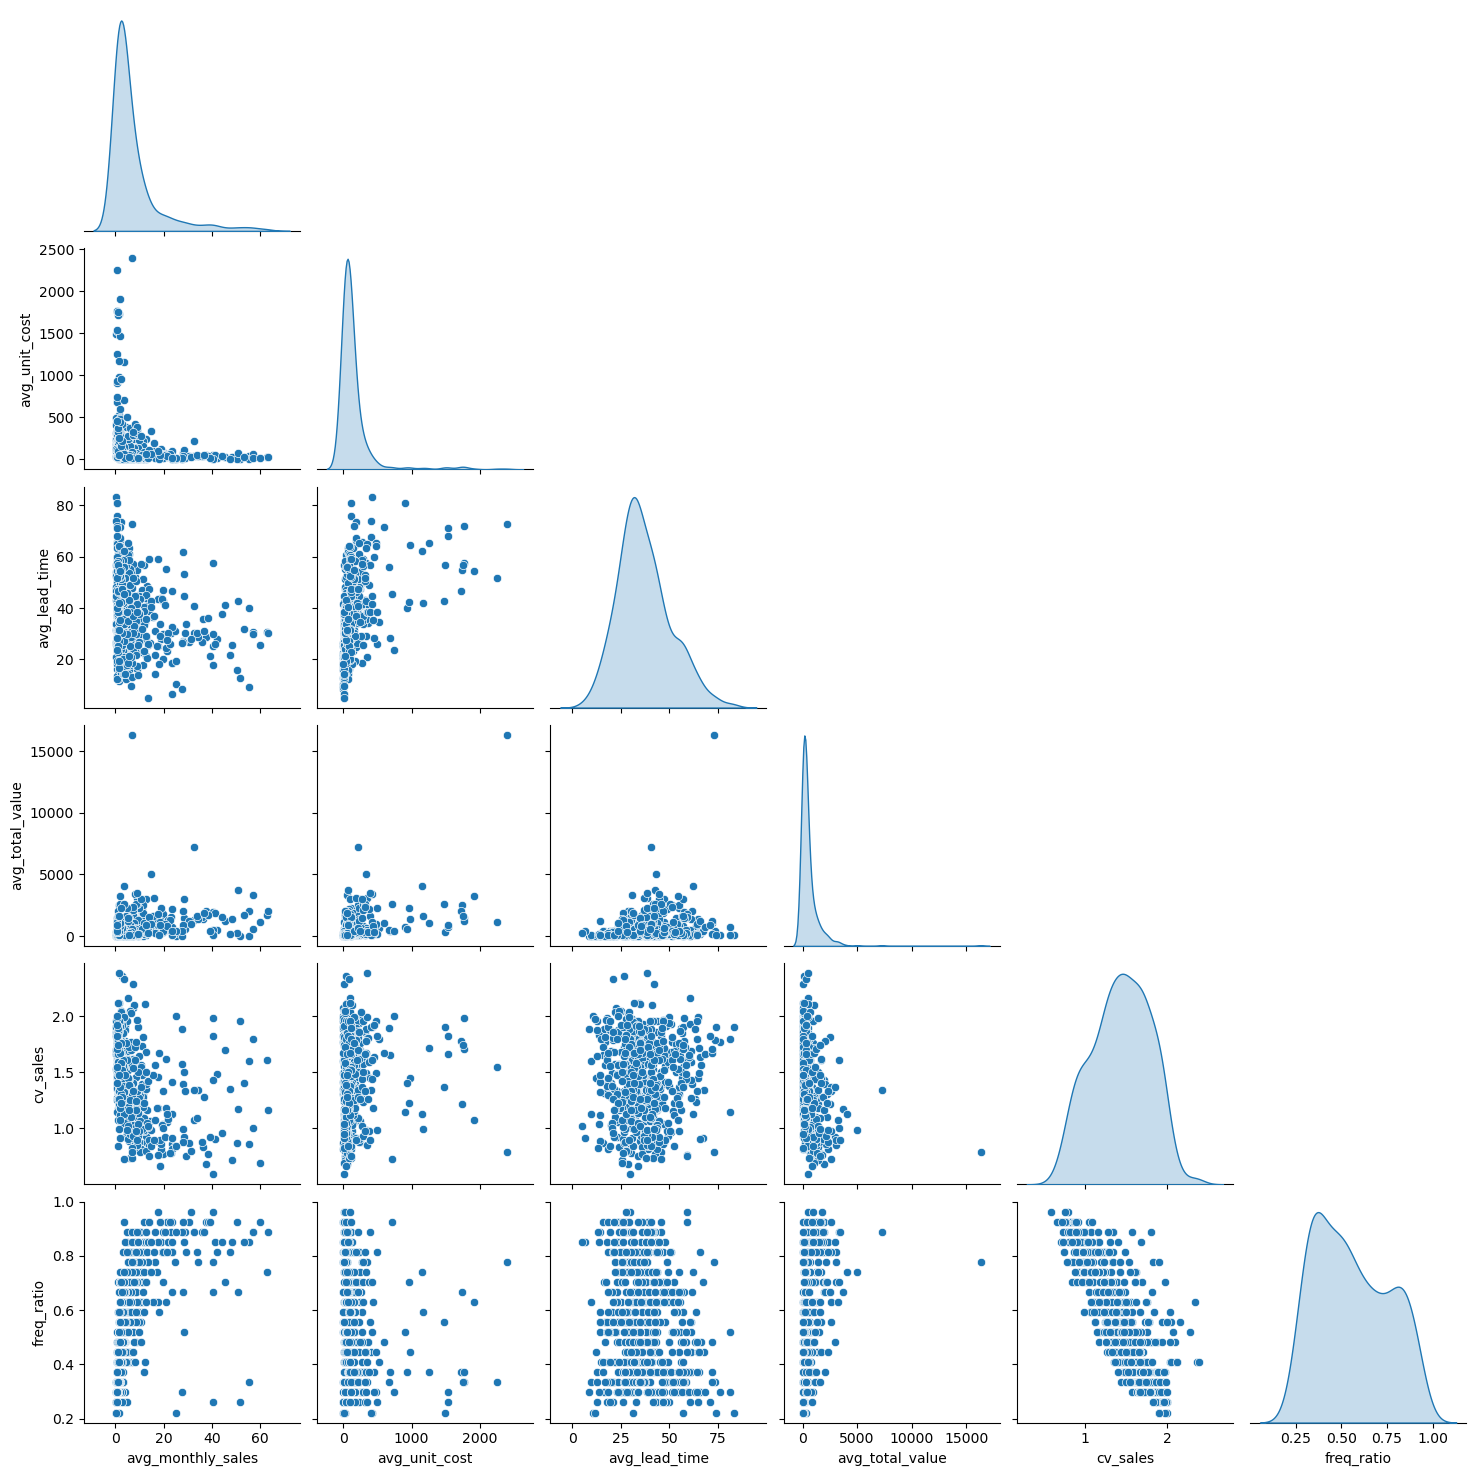

In [79]:
sns.pairplot(
    data=stats2,
    vars=raw_features,
    corner=True,
    diag_kind='kde'
)

In [80]:
# lower = better

scaler = StandardScaler()
stats2['sales_is'] = scaler.fit_transform(-stats2[['avg_monthly_sales']]) # more sales = better

scaler = StandardScaler()
stats2['cv_s'] = scaler.fit_transform(stats2[['cv_sales']]) # less coefficient of variation = better

scaler = StandardScaler()
stats2['freq_ratio_is'] = scaler.fit_transform(-stats2[['freq_ratio']]) # higher frequency = better

scaler = StandardScaler()
stats2['unit_cost_s'] = scaler.fit_transform(stats2[['avg_unit_cost']]) # lower unit cost = better

scaler = StandardScaler()
stats2['value_is'] = scaler.fit_transform(-stats2[['avg_total_value']]) # higher sales value = better

scaler = StandardScaler()
stats2['lt_is'] = scaler.fit_transform(-stats2[['avg_lead_time']]) # lower LT = better



stats2.columns

Index(['avg_monthly_sales', 'avg_unit_cost', 'avg_lead_time',
       'avg_total_value', 'cv_sales', 'freq_ratio', 'category', 'item_id',
       'sales_is', 'cv_s', 'freq_ratio_is', 'unit_cost_s', 'value_is',
       'lt_is'],
      dtype='object')

# 4️⃣ Dimensionality Reduction

Apply PCA:
	•	Use scaled and inverted features
	•	Visualize in 2D or 3D
	•	See how articles spread across “stability space”



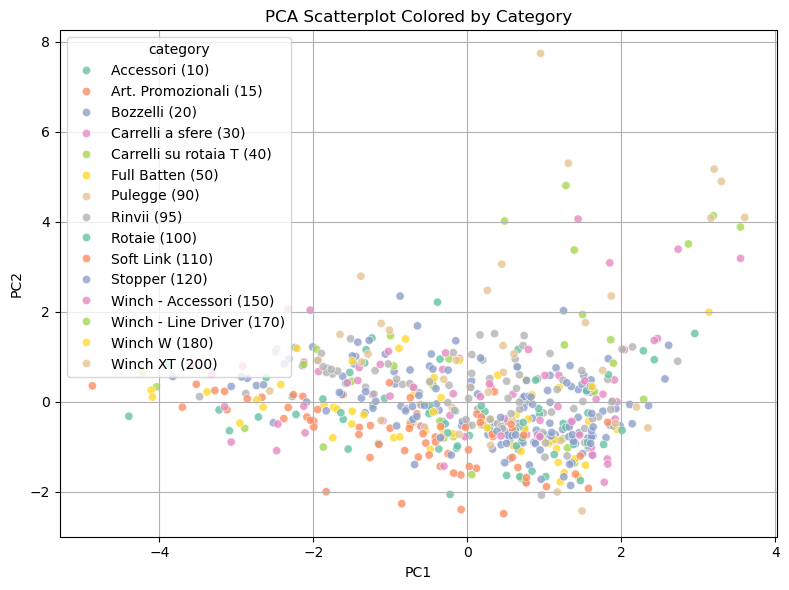

In [81]:
# 1. Fit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(stats2[scaled_features])

# 2. Build a DataFrame with PCA results
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['category'] = stats2['category'].values   # 👈 or any other column you want for hue

# 3. Plot with hue
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='category',      # 👈 add the hue here
    palette='Set2',
    alpha=0.8
)

plt.title('PCA Scatterplot Colored by Category')
plt.grid(True)
plt.tight_layout()
plt.show()

# 5️⃣ Clustering

Run K-Means on PCA input or directly on scaled features:
	•	Choose k = 3 to 6 to start
	•	Analyze:
	•	Cluster averages
	•	Cluster sizes
	•	Cluster stability patterns

Check:
	•	Are there tight stable clusters?
	•	Are there mixed clusters (stable but high-cost, etc.)?



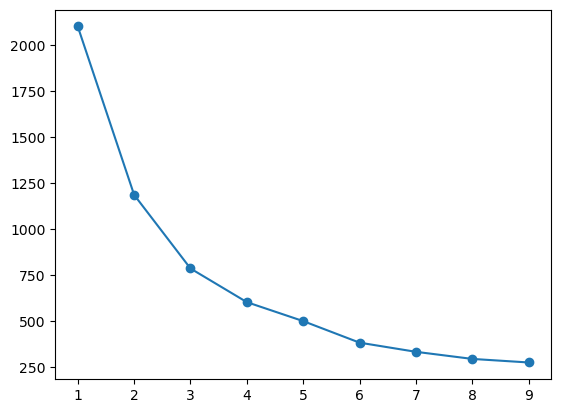

In [82]:
inertia = []
k_range = range(1, 10)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_pca)
    inertia.append(model.inertia_)

plt.plot(k_range, inertia, marker='o')

plt.show()

In [83]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(stats2[scaled_features])

# add lables
stats2.loc[stats2.index, 'cluster'] = clusters

# summarize
cluster_summary = stats2.loc[stats2.index].groupby('cluster')[scaled_features].mean()
display(cluster_summary)
print(stats2.cluster.value_counts())

,sales_is,unit_cost_s,lt_is,cv_s,freq_ratio_is
cluster,,,,,
0.0,0.431532,-0.182581,0.392276,0.684398,0.696534
1.0,-2.803433,-0.409079,0.602972,-0.949613,-1.383183
2.0,0.475237,1.218923,-1.635908,0.461657,0.700395
3.0,-0.088444,-0.201892,0.070492,-0.846977,-0.863221


cluster
0.0    251
3.0    197
2.0     86
1.0     47
Name: count, dtype: int64


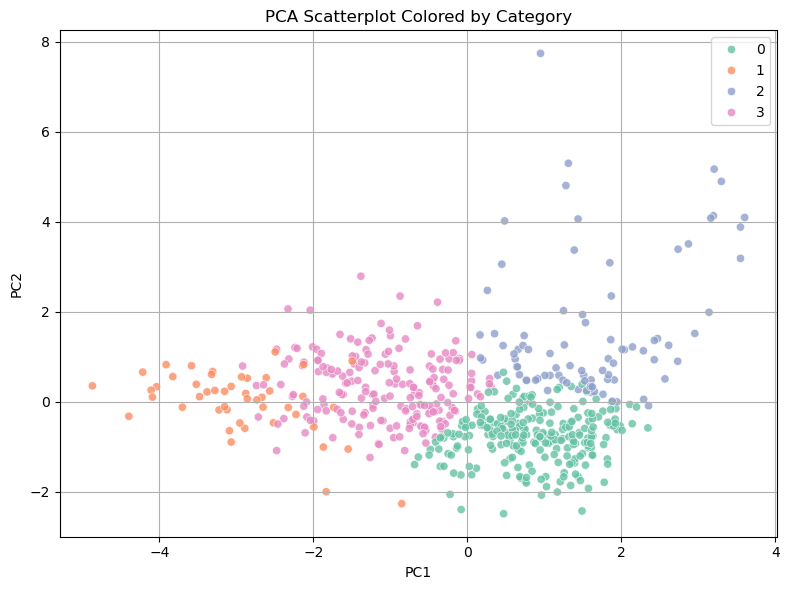

In [84]:
# 3. Plot with hue
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue=clusters,      # 👈 add the hue here
    palette='Set2',
    alpha=0.8
)

plt.title('PCA Scatterplot Colored by Category')
plt.grid(True)
plt.tight_layout()
plt.show()

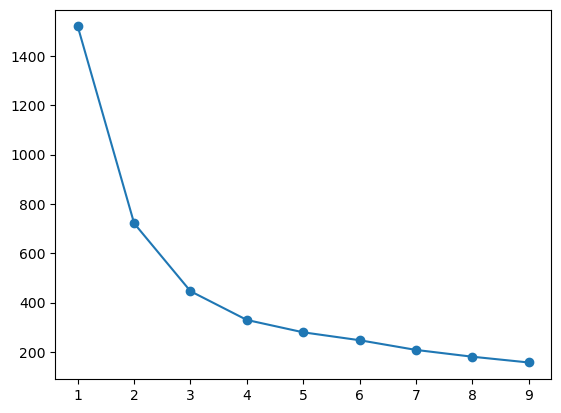

,sales_is,unit_cost_s,lt_is,cv_s,freq_ratio_is
cluster,,,,,
0.0,0.460527,-0.142347,0.317776,0.989547,0.930859
1.0,-3.034639,-0.414678,0.612221,-0.890129,-1.380506
2.0,-0.301360,-0.173017,-0.098212,-1.150801,-1.158978
3.0,0.267187,-0.265089,0.476730,-0.131436,-0.068925


cluster
0.0    251
3.0    197
2.0     86
1.0     47
Name: count, dtype: int64


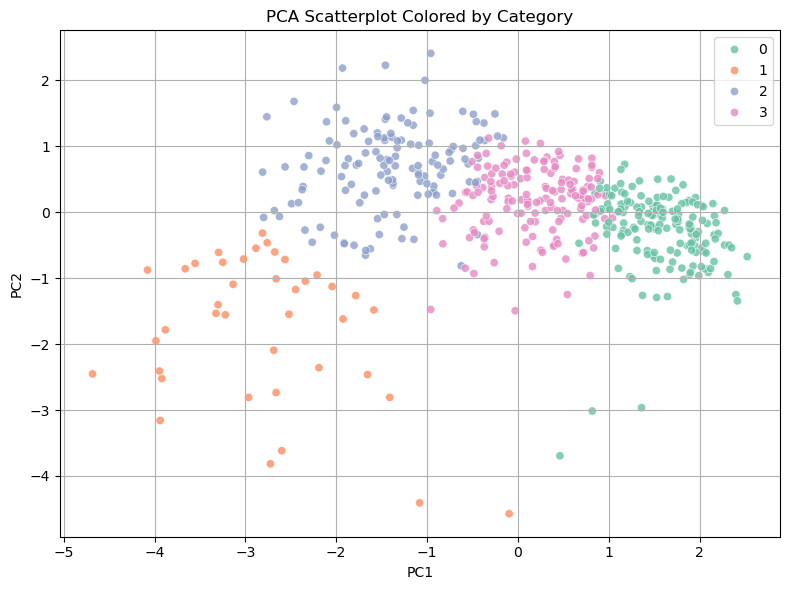

,category,item_id,sales_is,unit_cost_s,lt_is,cv_s,freq_ratio_is,cluster
4,Accessori (10),008HR,0.455236,-0.480141,1.179132,1.000992,1.131816,0.0
16,Accessori (10),7206,-0.129322,-0.443397,0.391702,-0.765779,-0.919059,2.0
17,Accessori (10),7208,-0.300657,-0.419843,-0.049637,-1.073988,-1.291945,2.0
19,Accessori (10),7210,-0.519027,-0.407183,-0.501086,-0.784827,-1.478388,2.0
20,Accessori (10),7212,-4.345526,-0.399933,-0.225518,-1.637346,-1.478388,1.0
...,...,...,...,...,...,...,...,...
1790,Winch XT (200),XT40CH,0.515707,1.024267,0.111215,-0.746741,-0.359729,3.0
1796,Winch XT (200),XT40R,0.623212,1.071480,0.631973,1.378239,1.318259,0.0
1797,Winch XT (200),XT44AL,0.267103,1.231437,-0.109314,-1.296933,-1.291945,2.0
1805,Winch XT (200),XT48AL,0.354450,1.972165,-0.643854,-2.035409,-1.851275,2.0


In [94]:
data = stats2[stats2.cluster.isin([0,1,3])][['category', 'item_id'] + scaled_features]
# 1. Fit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data[scaled_features])

# 2. Build a DataFrame with PCA results
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

inertia = []
k_range = range(1, 10)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_pca)
    inertia.append(model.inertia_)

plt.plot(k_range, inertia, marker='o')

plt.show()



k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(data[scaled_features])

# add lables
data.loc[data.index, 'cluster'] = clusters

# summarize
cluster_summary = data.loc[data.index].groupby('cluster')[scaled_features].mean()
display(cluster_summary)
print(stats2.cluster.value_counts())

# 3. Plot with hue
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue=clusters,      # 👈 add the hue here
    palette='Set2',
    alpha=0.8
)

plt.title('PCA Scatterplot Colored by Category')
plt.grid(True)
plt.tight_layout()
plt.show()
data

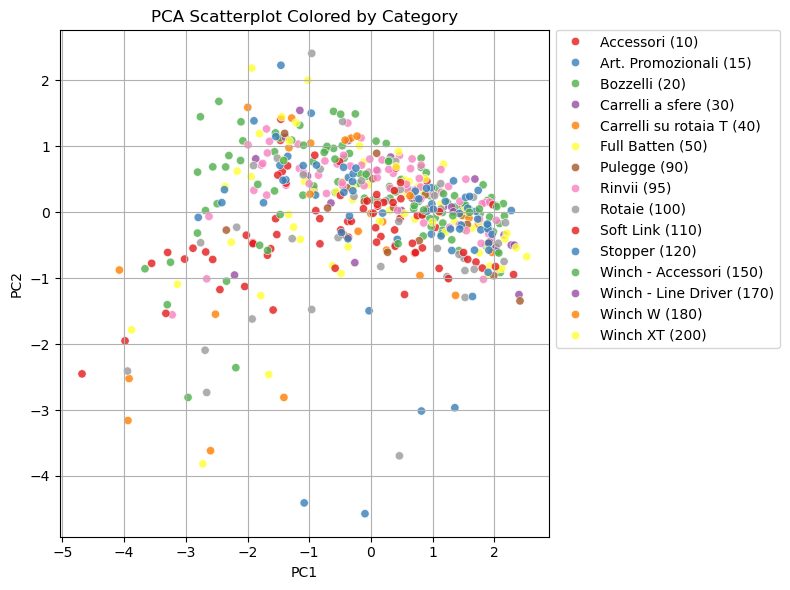

In [85]:
candidates = stats2[stats2.cluster.isin([0,1,3])][['category', 'item_id'] + raw_features + scaled_features]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(candidates[scaled_features])

# 2. Build a DataFrame with PCA results
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['category'] = candidates['category'].values   # 👈 or any other column you want for hue

# 3. Plot with hue
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='category',      # 👈 add the hue here
    palette='Set1',
    alpha=0.8
)
plt.legend(bbox_to_anchor=(1, 1.015), loc='upper left')
plt.title('PCA Scatterplot Colored by Category')
plt.grid(True)
plt.tight_layout()
plt.show()

In [86]:
all_candidates = pd.concat([
    candidates[['category', 'item_id'] + raw_features],
    outliers_sales[['category', 'item_id'] + raw_features]
], axis=0).reset_index().drop(columns=('index')).round(2)
all_candidates

,category,item_id,avg_monthly_sales,avg_unit_cost,avg_lead_time,avg_total_value,cv_sales,freq_ratio
0,Accessori (10),008HR,2.56,14.55,20.98,37.18,1.79,0.33
1,Accessori (10),7206,9.00,24.94,31.62,224.46,1.17,0.74
2,Accessori (10),7208,10.89,31.60,37.59,344.09,1.06,0.81
3,Accessori (10),7210,13.30,35.18,43.69,467.76,1.16,0.85
4,Accessori (10),7212,55.48,37.23,39.96,2065.58,0.87,0.85
...,...,...,...,...,...,...,...,...
509,Soft Link (110),R28.20,183.48,16.64,21.40,3053.13,0.58,0.96
510,Soft Link (110),R3.14,66.26,28.86,31.16,1912.24,1.17,0.93
511,Soft Link (110),RL6.1,64.96,21.61,21.68,1403.85,1.07,0.89
512,Stopper (120),509.112,160.59,38.87,32.18,6242.23,1.03,0.93


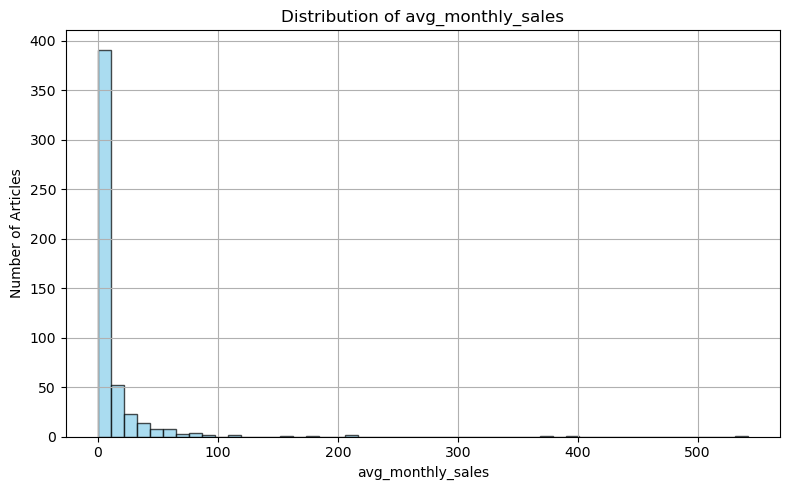

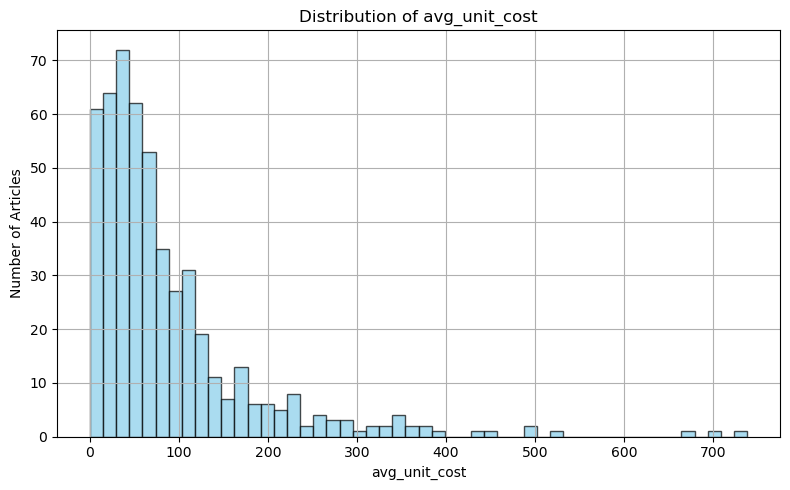

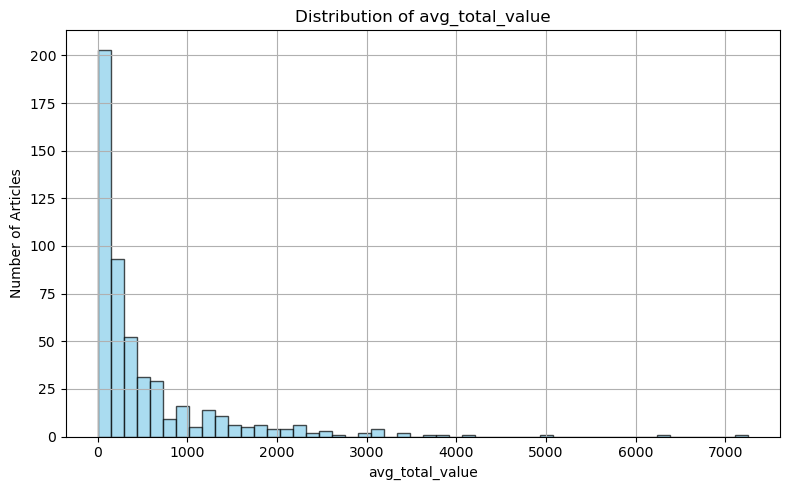

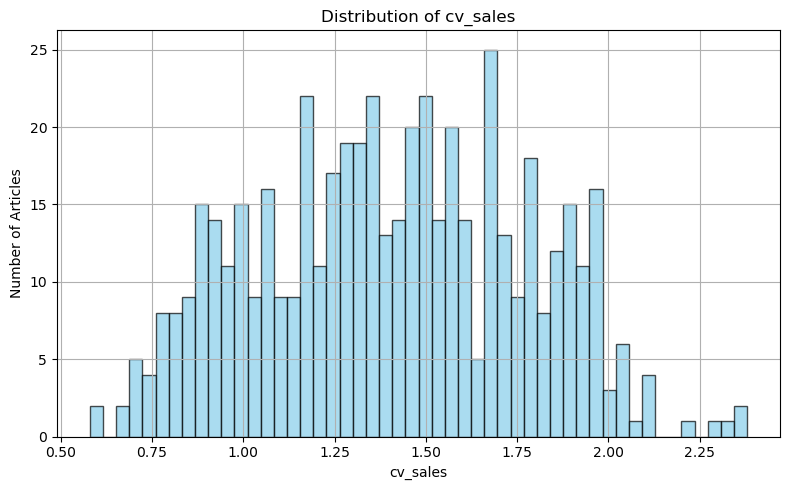

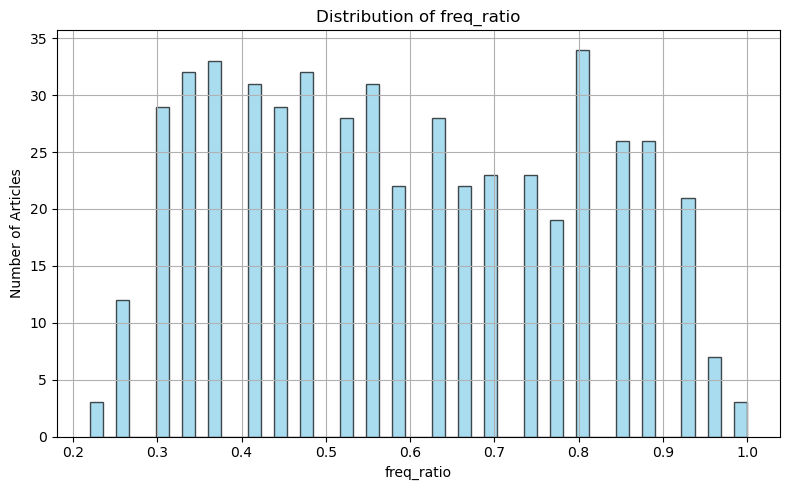

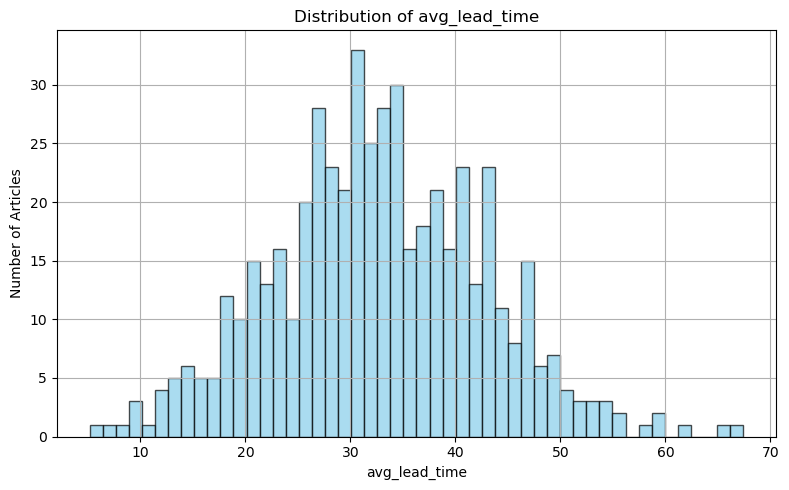

In [87]:
features_to_plot = ['avg_monthly_sales', 'avg_unit_cost', 'avg_total_value', 'cv_sales', 'freq_ratio', 'avg_lead_time']

for feature in features_to_plot:
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(all_candidates[feature].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Number of Articles')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# 6️⃣ Outlier Analysis

After clustering:
	•	Which points are far from cluster centers?
	•	Any very high unit_cost items that barely sell?
	•	Any super stable but extremely low volume articles?



# 7️⃣ Shortlisting for Stocking

Candidate logic:
	•	High frequency
	•	Low CV
	•	High enough volume (business relevant)
	•	Acceptable unit cost

Define thresholds or select top percentile candidates!

In [88]:
all_candidates.to_csv('../data/all_candidates.csv', index=False)